# Simulation & control of inverted pendulum

## Build cart model

In [1]:
import math
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt


In [2]:
def cartpend(y, t, u, m, M, L, g, d):

    x, dx, theta, dtheta = y
    Sy = math.sin(theta)
    Cy = math.cos(theta)
    D = m*L*L*(M+m*(1-Cy**2))
    
    y1 = dx
    y2 = (1/D)*(-m**2*L**2*g*Cy*Sy + m*L**2*(m*L*dtheta**2*Sy - d*dx)) + m*L*L*(1/D)*u
    y3 = dtheta
    y4 = (1/D)*((m+M)*m*g*L*Sy - m*L*Cy*(m*L*dtheta**2*Sy - d*dx)) - m*L*Cy*(1/D)*u

    dydt = [y1, y2, y3, y4]

    return dydt


In [3]:
u = 0
m = 1
M = 5
L = 2
g = -10
d = 1
y0 = [0, 0, math.pi, 0.1]
time_span = 10
frames = 30*time_span
t = np.linspace(0, time_span, frames)
y = odeint(cartpend, y0, t, args = (u, m, M, L, g, d))

## Plot result

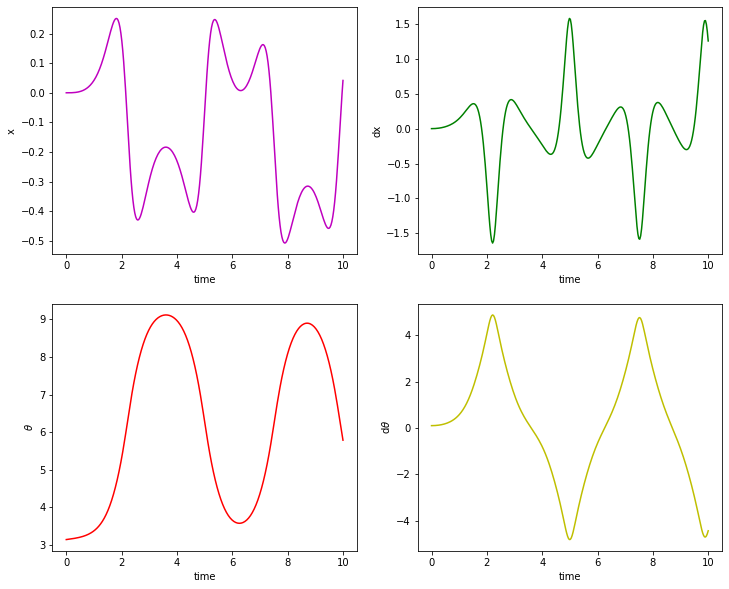

In [4]:
res_x = [row[0] for row in y]
res_dx = [row[1] for row in y]
res_theta = [row[2] for row in y]
res_dtheta = [row[3] for row in y]

plt.figure(figsize=(12,10))
plt.subplot(221)
plt.plot(t,res_x, 'm')
plt.xlabel('time')
plt.ylabel('x')

plt.subplot(222)
plt.plot(t,res_dx, 'g')
plt.xlabel('time')
plt.ylabel('dx')

plt.subplot(223)
plt.plot(t,res_theta, 'r')
plt.xlabel('time')
plt.ylabel(r'$\theta$')

plt.subplot(224)
plt.plot(t,res_dtheta, 'y')
plt.xlabel('time')
plt.ylabel('d' + r'$\theta$')
plt.show()



## Show animation

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML
from matplotlib import rc


fig = plt.figure()
ax = fig.add_subplot(111,autoscale_on=False,\
                     xlim=(-3,2),ylim=(-0.4,2.5))
ax.set_xlabel('position')
ax.axis('scaled')

ax.plot([-3,2],[-0.2,-0.2],'k-', lw=4)
mass1, = ax.plot([],[],linestyle='None',marker='s',\
                 markersize=40,markeredgecolor='k',\
                 color='orange',markeredgewidth=2)
mass2, = ax.plot([],[],linestyle='None',marker='o',\
                 markersize=20,markeredgecolor='k',\
                 color='orange',markeredgewidth=2)
line, = ax.plot([],[],'o-',color='black',lw=4,\
                markersize=6,markeredgecolor='k',\
                markerfacecolor='k')
time_template = 'time = %.1fs'
time_text = ax.text(0.05,0.9,'',transform=ax.transAxes)

def init():
    mass1.set_data([],[])
    mass2.set_data([],[])
    line.set_data([],[])
    time_text.set_text('')
    return line, mass1, mass2, time_text

def animate(i):
    mass1_x = res_x[i]
    mass1_y = -0.1
    mass2_x = res_x[i]+L*math.sin(res_theta[i])
    mass2_y = -L*math.cos(res_theta[i])

    mass1.set_data([mass1_x], [mass1_y])
    mass2.set_data([mass2_x], [mass2_y])

    line.set_data([mass1_x,mass2_x],[mass1_y,mass2_y])
    time_text.set_text(time_template % t[i])
    return line, mass1, mass2, time_text

ani_a = animation.FuncAnimation(fig, animate, \
         np.arange(1,len(t)), \
         interval=40,blit=False,init_func=init)
ani_a.save('Pendulum_free.mp4',fps=30)



## Add pole placement



In [5]:
import scipy.linalg as la
from scipy import signal

# linearize
# dx = Ax + Bu
s = 1
A = np.array([
    [0, 1, 0, 0],
    [0, -d/M, -m*g/M, 0],
    [0, 0, 0, 1],
    [0, -s*d/(M*L), -s*(m+M)*g/(M*L), 0],
 ]) 

B = np.array([
    [0],
    [1/M],
    [0],
    [s*1/(M*L)],
])

# eig_A = la.eig(A)
i=-3.05
eig_target = np.array([-1.1+i, -1.2+i, -1.3+i, -1.4+i])
fsf1 = signal.place_poles(A, B, eig_target)
Kgain = fsf1.gain_matrix
# print(Kgain[0][0])
eig_AKx = la.eig(A-B.dot(Kgain))
# eig_AKx[0]

In [6]:
def cartpend_poleplace(y, t, K, m, M, L, g, d):

    x, dx, theta, dtheta = y
    u = -(K[0][0] * x + K[0][1] * dx + K[0][2] * (theta-np.pi) + K[0][3] * dtheta)
    Sy = math.sin(theta)
    Cy = math.cos(theta)
    D = m*L*L*(M+m*(1-Cy**2))
    
    y1 = dx
    y2 = (1/D)*(-m**2*L**2*g*Cy*Sy + m*L**2*(m*L*dtheta**2*Sy - d*dx)) + m*L*L*(1/D)*u
    y3 = dtheta
    y4 = (1/D)*((m+M)*m*g*L*Sy - m*L*Cy*(m*L*dtheta**2*Sy - d*dx)) - m*L*Cy*(1/D)*u

    dydt = [y1, y2, y3, y4]

    return dydt


y0 = [0, 0, math.pi+0.5, 0]
time_span = 10
frames = 30*time_span
t = np.linspace(0, time_span, frames)
y = odeint(cartpend_poleplace, y0, t, args = (Kgain, m, M, L, g, d))


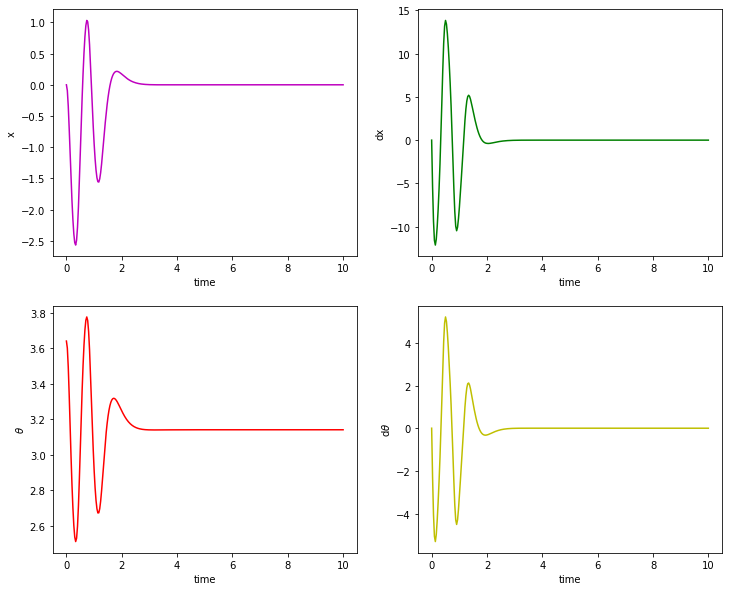

In [7]:
res_x = [row[0] for row in y]
res_dx = [row[1] for row in y]
res_theta = [row[2] for row in y]
res_dtheta = [row[3] for row in y]

plt.figure(figsize=(12,10))
plt.subplot(221)
plt.plot(t,res_x, 'm')
plt.xlabel('time')
plt.ylabel('x')

plt.subplot(222)
plt.plot(t,res_dx, 'g')
plt.xlabel('time')
plt.ylabel('dx')

plt.subplot(223)
plt.plot(t,res_theta, 'r')
plt.xlabel('time')
plt.ylabel(r'$\theta$')

plt.subplot(224)
plt.plot(t,res_dtheta, 'y')
plt.xlabel('time')
plt.ylabel('d' + r'$\theta$')
plt.show()


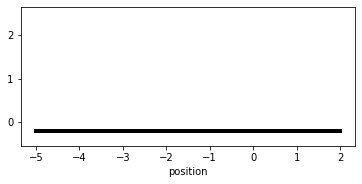

In [8]:
import matplotlib.animation as animation
from IPython.display import HTML
from matplotlib import rc


fig = plt.figure()
ax = fig.add_subplot(111,autoscale_on=False,\
                     xlim=(-5,2),ylim=(-0.4,2.5))
ax.set_xlabel('position')
ax.axis('scaled')

ax.plot([-5,2],[-0.2,-0.2],'k-', lw=4)
mass1, = ax.plot([],[],linestyle='None',marker='s',\
                 markersize=40,markeredgecolor='k',\
                 color='orange',markeredgewidth=2)
mass2, = ax.plot([],[],linestyle='None',marker='o',\
                 markersize=20,markeredgecolor='k',\
                 color='orange',markeredgewidth=2)
line, = ax.plot([],[],'o-',color='black',lw=4,\
                markersize=6,markeredgecolor='k',\
                markerfacecolor='k')
time_template = 'time = %.1fs'
time_text = ax.text(0.05,0.9,'',transform=ax.transAxes)

def init():
    mass1.set_data([],[])
    mass2.set_data([],[])
    line.set_data([],[])
    time_text.set_text('')
    return line, mass1, mass2, time_text

def animate(i):
    mass1_x = res_x[i]
    mass1_y = -0.1
    mass2_x = res_x[i]+L*math.sin(res_theta[i])
    mass2_y = -L*math.cos(res_theta[i])

    mass1.set_data([mass1_x], [mass1_y])
    mass2.set_data([mass2_x], [mass2_y])

    line.set_data([mass1_x,mass2_x],[mass1_y,mass2_y])
    time_text.set_text(time_template % t[i])
    return line, mass1, mass2, time_text

ani_a = animation.FuncAnimation(fig, animate, \
         np.arange(1,len(t)), \
         interval=40,blit=False,init_func=init)
ani_a.save('Pendulum_Control.mp4',fps=30)

## Pole calculation with LQR

In [9]:
Q = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 10, 0],
    [0, 0, 0, 10],
 ]) 

R = [[0.1]]

http://www.mwm.im/lqr-controllers-with-python/

In [10]:
import numpy as np
import scipy.linalg
 
def lqr(A,B,Q,R):
    """Solve the continuous time lqr controller.
    
    dx/dt = A x + B u
    
    cost = integral x.T*Q*x + u.T*R*u
    """
    #ref Bertsekas, p.151
    
    #first, try to solve the ricatti equation
    X = np.matrix(scipy.linalg.solve_continuous_are(A, B, Q, R))
    
    #compute the LQR gain
    K = np.matrix(scipy.linalg.inv(R)*(B.T*X))
    
    eigVals, eigVecs = scipy.linalg.eig(A-B*K)
    
    return K, X, eigVals

In [11]:
K, X, eigVals = lqr(A,B,Q,R)
K = np.array([K.A1]) 
eigVals

array([-2.98935495+0.j       , -2.04870466+0.j       ,
       -0.57863283+0.4260667j, -0.57863283-0.4260667j])

In [12]:
y0 = [0, 0, math.pi+0.5, 0]
time_span = 10
frames = 30*time_span
t = np.linspace(0, time_span, frames)
y = odeint(cartpend_poleplace, y0, t, args = (K, m, M, L, g, d))

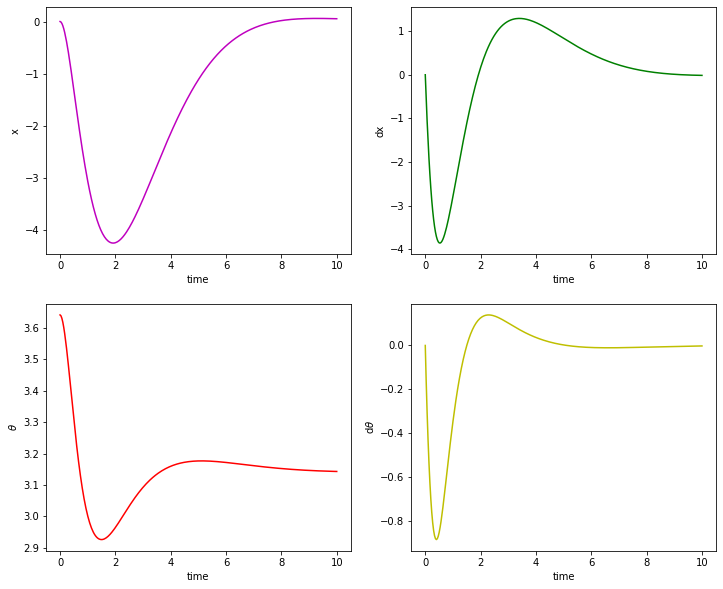

In [13]:
res_x = [row[0] for row in y]
res_dx = [row[1] for row in y]
res_theta = [row[2] for row in y]
res_dtheta = [row[3] for row in y]

plt.figure(figsize=(12,10))
plt.subplot(221)
plt.plot(t,res_x, 'm')
plt.xlabel('time')
plt.ylabel('x')

plt.subplot(222)
plt.plot(t,res_dx, 'g')
plt.xlabel('time')
plt.ylabel('dx')

plt.subplot(223)
plt.plot(t,res_theta, 'r')
plt.xlabel('time')
plt.ylabel(r'$\theta$')

plt.subplot(224)
plt.plot(t,res_dtheta, 'y')
plt.xlabel('time')
plt.ylabel('d' + r'$\theta$')
plt.show()

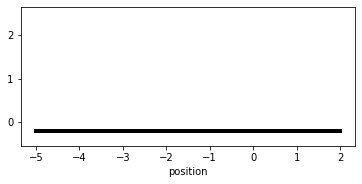

In [14]:
import matplotlib.animation as animation
from IPython.display import HTML
from matplotlib import rc


fig = plt.figure()
ax = fig.add_subplot(111,autoscale_on=False,\
                     xlim=(-5,2),ylim=(-0.4,2.5))
ax.set_xlabel('position')
ax.axis('scaled')

ax.plot([-5,2],[-0.2,-0.2],'k-', lw=4)
mass1, = ax.plot([],[],linestyle='None',marker='s',\
                 markersize=40,markeredgecolor='k',\
                 color='orange',markeredgewidth=2)
mass2, = ax.plot([],[],linestyle='None',marker='o',\
                 markersize=20,markeredgecolor='k',\
                 color='orange',markeredgewidth=2)
line, = ax.plot([],[],'o-',color='black',lw=4,\
                markersize=6,markeredgecolor='k',\
                markerfacecolor='k')
time_template = 'time = %.1fs'
time_text = ax.text(0.05,0.9,'',transform=ax.transAxes)

def init():
    mass1.set_data([],[])
    mass2.set_data([],[])
    line.set_data([],[])
    time_text.set_text('')
    return line, mass1, mass2, time_text

def animate(i):
    mass1_x = res_x[i]
    mass1_y = -0.1
    mass2_x = res_x[i]+L*math.sin(res_theta[i])
    mass2_y = -L*math.cos(res_theta[i])

    mass1.set_data([mass1_x], [mass1_y])
    mass2.set_data([mass2_x], [mass2_y])

    line.set_data([mass1_x,mass2_x],[mass1_y,mass2_y])
    time_text.set_text(time_template % t[i])
    return line, mass1, mass2, time_text

ani_a = animation.FuncAnimation(fig, animate, \
         np.arange(1,len(t)), \
         interval=40,blit=False,init_func=init)
ani_a.save('Pendulum_Control_LQR.mp4',fps=30)